In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import pingouin as pg
from mdi_computation import mdi_compute, smdi_compute
%matplotlib widget

<h1 align="center">Organizing and Loading Data</h1>

In [39]:
compiled_csv_paths = glob.glob("./protein_extract_spectra/*scans.csv")
wavenumber = pd.read_csv("./wavenumber.csv")
pe24d, pe24, pe32, pe48 = [pd.read_csv(path) for path in compiled_csv_paths]

scan_number_dataframes = [pe24, pe24d, pe32, pe48]

for df in scan_number_dataframes:
    df["average"] = df.mean(axis=1)

<h1 align="center">Visualizing Spectra</h1>

In [38]:
colors = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00"]
scan_labels = ["24", "24 (Danilo)", "32", "48"]

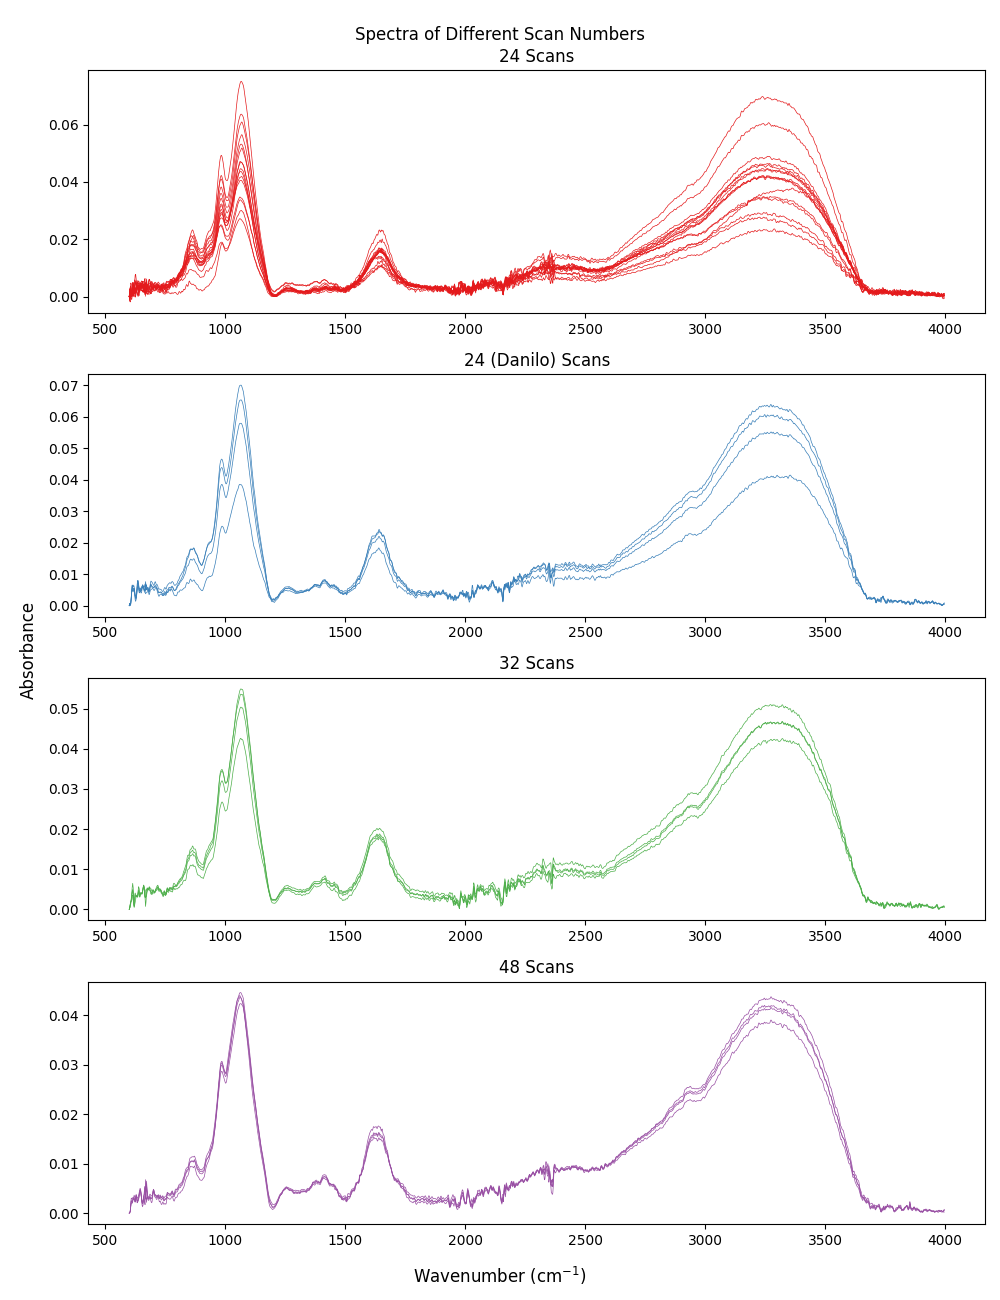

In [40]:
all_scans_fig, asf_axes = plt.subplots(4, 1, figsize=(10, 13))

for axis, name, color, df in zip(
    asf_axes, scan_labels, colors, scan_number_dataframes
):
    for replicate in df.columns:
        spectrum = df[replicate]
        axis.plot(wavenumber, spectrum, color=color, linewidth=0.5)

    axis.set(title=f"{name} Scans")

all_scans_fig.suptitle("Spectra of Different Scan Numbers")
all_scans_fig.supxlabel("Wavenumber (cm$^{-1}$)")
all_scans_fig.supylabel("Absorbance")

all_scans_fig.tight_layout()

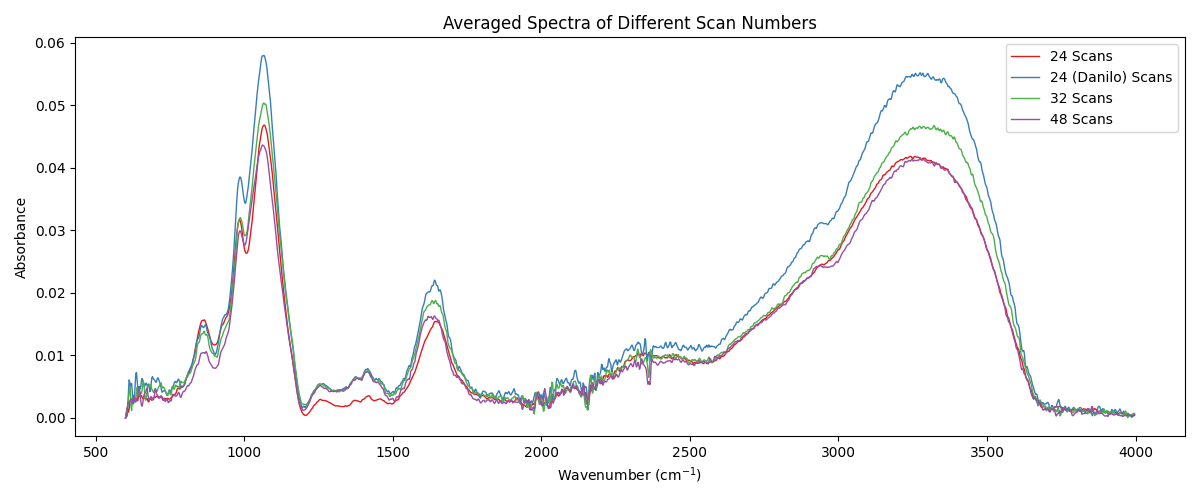

In [41]:
ave_scans_fig, ave_axes = plt.subplots(1, 1, figsize=(12, 5))

for name, color, df in zip(scan_labels, colors, scan_number_dataframes):
    spectrum = df["average"]
    ave_axes.plot(
        wavenumber, spectrum, color=color, linewidth=1, label=f"{name} Scans"
    )

ave_axes.legend()
ave_axes.set(
    title="Averaged Spectra of Different Scan Numbers",
    xlabel="Wavenumber (cm$^{-1}$)",
    ylabel="Absorbance",
)
ave_scans_fig.tight_layout()

<h1 align="center">MDI Computation & Analysis</h1>

In [42]:
import pandas as pd
import glob
import os


def mdi_compute(input_dir: str, output_path: str):
    os.makedirs(output_path, exist_ok=True)

    # Loading Data
    csv_paths = glob.glob(f"{input_dir}/*.csv")
    wave_no = pd.read_csv("./wavenumber.csv")  # Ensure file path is correct

    scan_no_dict = {
        os.path.basename(path).replace(".csv", ""): pd.read_csv(path)
        for path in csv_paths
    }

    # Computing MDI
    lp = 3996.73391
    rp = 599.51009
    i = wave_no["wavenumber"]

    result_dict = {}  # Store MDI values in a dictionary first

    for key, df in scan_no_dict.items():
        mdi_results = []

        for sample in df.columns:
            p = df[sample]
            md_lp = sum(((p**2) + ((i - lp)) ** 2) ** 0.5)
            md_rp = sum(((p**2) + ((rp - i)) ** 2) ** 0.5)
            mdi = md_rp - md_lp
            mdi_results.append(mdi)

        result_dict[key] = mdi_results

    # Convert dictionary to DataFrame
    result_df = pd.DataFrame.from_dict(result_dict, orient="index").transpose()

    result_df.to_csv(f"{output_path}/master_mdi.csv", index=False)


def smdi_compute(input_dir: str, output_path: str):
    os.makedirs(output_path, exist_ok=True)

    # Loading Data
    master_mdi_path = glob.glob(f"{input_dir}/master_mdi.csv")
    if not master_mdi_path:
        raise FileNotFoundError("master_mdi.csv not found in input directory.")
    
    master_mdi = pd.read_csv(master_mdi_path[0])

    # Computing SMDI
    result_df = pd.DataFrame()

    global_max = master_mdi.max().max()
    global_min = master_mdi.min().min()

    mdi_range = global_max - global_min
    if mdi_range == 0:
        raise ValueError("MDI range is zero, normalization cannot be performed.")

    result_df = (master_mdi - global_min) / mdi_range

    result_df.to_csv(f"{output_path}/master_smdi.csv", index=False)


if __name__ == "__main__":
    pass


In [43]:
mdi_compute("protein_extract_spectra", "mdi_results")
#smdi_compute("mdi_results", "mdi_results")

In [44]:
mdi_results = pd.read_csv("./mdi_results/master_mdi.csv")

In [45]:
mdi_results

,protein_extract_24d_scans,protein_extract_24_scans,protein_extract_32_scans,protein_extract_48_scans
0,-0.012557,-0.012820,-0.012600,-0.012206
1,-0.012479,-0.013158,-0.012833,-0.012604
2,-0.012967,-0.013227,-0.012454,-0.012682
3,NaN,-0.012229,NaN,NaN
4,NaN,-0.012552,NaN,NaN
5,NaN,-0.012168,NaN,NaN
6,NaN,-0.012417,NaN,NaN
7,NaN,-0.012371,NaN,NaN
8,NaN,-0.012293,NaN,NaN
9,NaN,-0.012776,NaN,NaN


<h2 align="center">Visualization</h2>

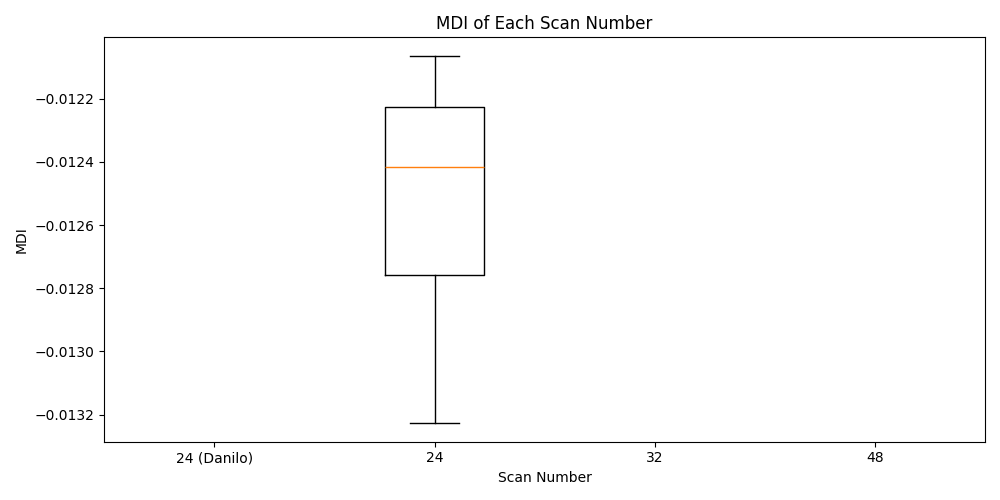

In [46]:
plt.close("all")
mdi_box, box_axis = plt.subplots(1, 1, figsize=(10, 5))

pooled_mdi_data = [mdi_results[column] for column in mdi_results.columns]

box_axis.boxplot(x=pooled_mdi_data)
box_axis.set(
    title="MDI of Each Scan Number",
    xlabel="Scan Number",
    ylabel="MDI",
    xticklabels=['24 (Danilo)', "24", "32", "48"],
)

mdi_box.tight_layout()

<h2 align="center">Statistical Analyses</h2>

<h3 align="center">Test for Normality (Shapiro-Wilk Test)</h3>

In [47]:
pg.normality(mdi_results, method="normaltest", alpha=0.05).round(3)

c:\Users\Danilo Pudolin Jr\AppData\Local\Programs\Python\Python313\Lib\site-packages\pingouin\distribution.py:230: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stats = numdata.apply(lambda x: func(x.dropna()), result_type="expand", axis=0).T
c:\Users\Danilo Pudolin Jr\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.
  return hypotest_fun_in(*args, **kwds)


,W,pval,normal
protein_extract_24d_scans,NaN,NaN,False
protein_extract_24_scans,1.506,0.471,True
protein_extract_32_scans,NaN,NaN,False
protein_extract_48_scans,NaN,NaN,False


<h3 align="center">Test for Homogeneity of Variances (Levene's Test)</h3>

In [48]:
pg.homoscedasticity(mdi_results, method="levene").round(3)

,W,pval,equal_var
levene,NaN,NaN,False


<h3 align="center">Group Comparison (One-Way ANOVA)</h3>

In [49]:
mdi_results_melted = mdi_results.melt(var_name="scan_number", value_name="mdi")

In [50]:
pg.anova(mdi_results_melted, dv="mdi", between="scan_number", detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,scan_number,8.312479e-08,3,2.770826e-08,0.248921,0.861133,0.035994
1,Within,2.226267e-06,20,1.113134e-07,NaN,NaN,NaN
